# From PyTorch to TensorFlow to Coral TPU
## Introduction
### In this article I will be showing you how to convert a PyTorch model to a TensorFlow model and run a TensorFlow model on a Coral TPU. To demonstrate this I will be testing the model son the mnist dataset which consits of handwritten digits. Also, you should know Python and some PyTorch.  This is the link for the original model: https://github.com/neel-kumar/deep-learning-mnist/blob/master/mnist-CNN.ipynb

In [1]:
import os
from PIL import Image
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
def open_jpg(filename):
    return Image.open(filename)

In [3]:
def save_jpg(a, filename):
    ia = (a * 255).astype(np.uint8)
    ia = np.reshape(ia, (28,28))
    Image.fromarray(ia).save(filename)

In [4]:
def show_img(a, dim=(28, 28)):
    img = np.reshape(a, dim)
    imgplot = plt.imshow(img, cmap = "gray")
    plt.show()

In [5]:
# https://stackoverflow.com/questions/37660312/how-to-run-tensorflow-on-cpu

# Uncomment following to disable GPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

print(tf.test.gpu_device_name())

GPU found
/device:GPU:0


## Keras Model
### TensorFlow includes an API called Keras which helps you build Neural Networks at the high level. This means that you only have to specify a few things and the rest it taken care by the computer. I chose to do this becase Keras provided me with all of the controlls I could need while not being that complicated. Alright now lets go through the model in the cell just below(If you want to see the original model go to the link at the top). Please note that this inside of a function so that if we want this model we just call the function and it creates the model. 
### Now lets look at the model. First we give it a name, which is in this case "mnist-CNN-tf". All the other layers are then added to the empty model to create the final model. 
- Line 2: Create the model and give it a name
- Line 3: Conv2D
- Line 4: Average Pool
- Line 5: Conv2D
- Line 6: Flattens the layer
- Line 7: Dense is a linear layer
- Line 8: Dense is output layer

In [6]:
def get_model():
    model = models.Sequential(name = "mnist-CNN-tf")
    model.add(layers.Conv2D(8, 3, padding = 'same', activation='relu', input_shape=(28, 28, 1), name = "layer1"))
    model.add(layers.AveragePooling2D((2, 2), name = "layer2"))
    model.add(layers.Conv2D(13, 3, padding = 'same', activation='relu', name = "layer3"))
    model.add(layers.Flatten(name = "layer4"))
    model.add(layers.Dense(14*14*13, name = "layer5"))
    model.add(layers.Dense(10, name = "layer6"))
    return model

In [7]:
model = get_model()
model.summary()

Model: "mnist-CNN-tf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
layer2 (AveragePooling2D)    (None, 14, 14, 8)         0         
_________________________________________________________________
layer3 (Conv2D)              (None, 14, 14, 13)        949       
_________________________________________________________________
layer4 (Flatten)             (None, 2548)              0         
_________________________________________________________________
layer5 (Dense)               (None, 2548)              6494852   
_________________________________________________________________
layer6 (Dense)               (None, 10)                25490     
Total params: 6,521,371
Trainable params: 6,521,371
Non-trainable params: 0
____________________________________________

In [8]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0

In [9]:
save_jpg(x_test[1], "files_0.jpg")
#a = x_test[0] * 255
#ia = (a * 255).astype(np.uint8)
#ia = np.reshape(ia, (28,28))
# import pdb; pdb.set_trace()
#Image.fromarray(ia)

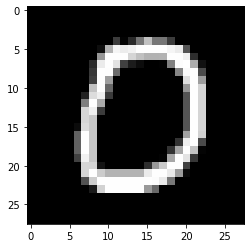

In [10]:
show_img(x_test[10])

In [11]:
x_train.shape

(60000, 28, 28)

In [12]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [13]:
x_train.shape

(60000, 28, 28, 1)

In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [15]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [16]:
print(datetime.now())
model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))
print(datetime.now())

2021-01-10 13:56:01.898178
Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1480 - accuracy: 0.9551 - val_loss: 0.0593 - val_accuracy: 0.9812
Epoch 2/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0594 - accuracy: 0.9812 - val_loss: 0.0536 - val_accuracy: 0.9822
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0466 - accuracy: 0.9857 - val_loss: 0.0488 - val_accuracy: 0.9843
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0344 - accuracy: 0.9895 - val_loss: 0.0450 - val_accuracy: 0.9854
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0306 - accuracy: 0.9904 - val_loss: 0.0504 - val_accuracy: 0.9847
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 0.0652 - val_accuracy: 0.9819
Epoch 7/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0246 - accuracy: 0.9917 - val_loss: 0.0524 - 

In [17]:
def convert_to_tflite(model):
    # Convert the tensorflow model into a tflite file.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model.
    with open('model.tflite', 'wb') as f:
        f.write(tflite_model)